# **A Comprehensive Framework for Video Classification and Action Recognition Using Deep Learning**

##### *Kakarla Rajinikanth*

<p align="center">
  <img src="images/intro.png" width="500">
</p>


This research presents an advanced deep learning framework for **video classification and action recognition**, leveraging **ConvLSTM** and **LRCN** architectures to model both spatial and temporal dependencies in video sequences. By systematically extracting and analyzing motion patterns, the system demonstrates high classification accuracy, achieving **85-90%** on the **UCF50 dataset**. The framework is designed for applications in **security, surveillance, and motion analysis**, offering robust performance in dynamic environments requiring real-time human activity recognition.

**Required Installations**

In [1]:
# %pip install opencv-python pafy numpy tensorflow matplotlib ipython scikit-learn

In [2]:
# https://www.kaggle.com/datasets/rajinikanthkakarla/ucf50-latest-version/data

In [3]:
# https://graphviz.gitlab.io/download/#windows -- graphviz-12.2.1 (64-bit) EXE installer [sha256]

**Import libraries**

In [4]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from IPython.display import display, Video

%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

**Setting Seed for Reproducibility**

In [5]:
seed_constant = 64
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

**Random Selection of 20 Action Classes from the Dataset**

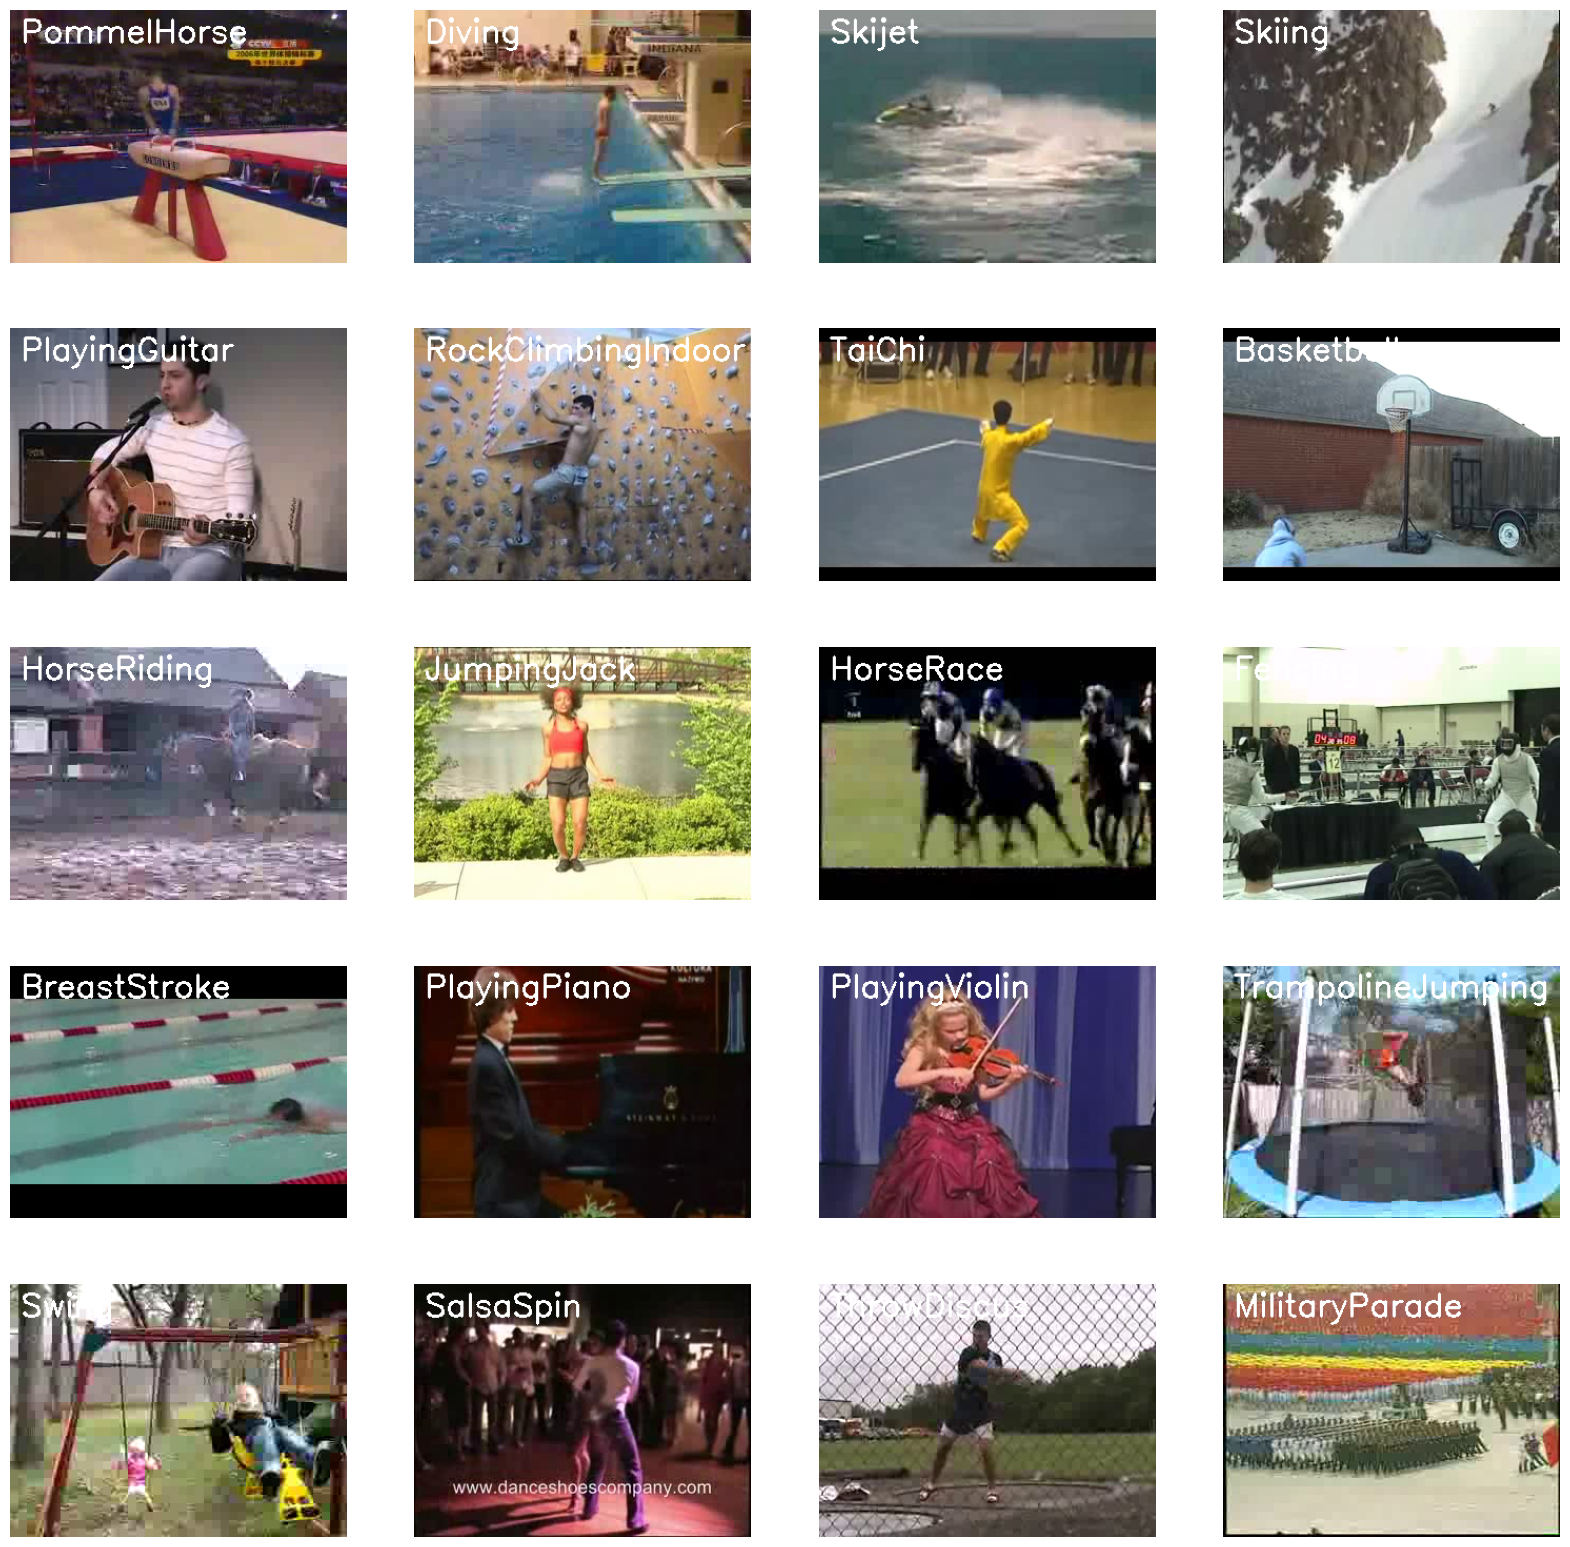

In [6]:
plt.figure(figsize = (20, 20))

all_classes_names = os.listdir('UCF50')

random_range = random.sample(range(len(all_classes_names)), 20)

for counter, random_index in enumerate(random_range, 1):
    selected_class_Name = all_classes_names[random_index]
    video_files_names_list = os.listdir(f'UCF50/{selected_class_Name}')
    selected_video_file_name = random.choice(video_files_names_list)
    video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')
    _, bgr_frame = video_reader.read()
    video_reader.release()
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

**Defining Image Dimensions, Sequence Length, and Dataset Parameters**

In [7]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

SEQUENCE_LENGTH = 24

DATASET_DIR = "UCF50"

CLASSES_LIST = ["WalkingWithDog", "TaiChi", "Swing", "Biking"]

**Function for Extracting and Preprocessing Video Frames**

In [8]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    
    video_reader.release()
    return frames_list

**Function for Creating the Video Classification Dataset and Encoding Labels**

In [9]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []
    
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)
            
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)  
    
    return features, labels, video_files_paths

features, labels, video_files_paths = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: Biking


In [10]:
one_hot_encoded_labels = to_categorical(labels)

**Splitting the Dataset into Training and Testing Sets**

In [11]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)

#### **Convolutional LSTM**

<p align="center">
  <img src="images/lstm.png" width="500">
</p>


Convolutional Long Short-Term Memory (ConvLSTM) is an advanced deep learning architecture that integrates Convolutional Neural Networks (CNNs) with Long Short-Term Memory (LSTM) networks to model spatial and temporal dependencies in sequential data. By replacing fully connected operations in LSTMs with convolutional layers, ConvLSTMs efficiently capture motion patterns in video sequences, making them highly effective for action recognition and spatiotemporal forecasting tasks.

**Creating the ConvLSTM Model**

In [12]:
def create_convlstm_model():
    model = Sequential()
    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape=(SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters=14, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(TimeDistributed(Dropout(0.2)))
    
    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         recurrent_dropout=0.2, return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    
    model.add(Flatten()) 
    model.add(Dense(len(CLASSES_LIST), activation="softmax"))
    
    model.summary()
    return model

**Initializing and Visualizing the Model**

In [13]:
convlstm_model = create_convlstm_model()
print("Model Created Successfully!")

c:\Users\rajin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 24, 62, 62, 4)  │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d (MaxPooling3D)    │ (None, 24, 31, 31, 4)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 24, 31, 31, 4)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 24, 29, 29, 8)  │         3,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_1 (MaxPooling3D)  │ (None, 24, 15, 15, 8)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 24, 15, 15, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_2 (ConvLSTM2D)      │ (None, 24, 13, 13, 14) │        11,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_2 (MaxPooling3D)  │ (None, 24, 7, 7, 14)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 24, 7, 7, 14)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_3 (ConvLSTM2D)      │ (None, 24, 5, 5, 16)   │        17,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling3d_3 (MaxPooling3D)  │ (None, 24, 3, 3, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3456)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │        13,828 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,828 (182.92 KB)

 Trainable params: 46,828 (182.92 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


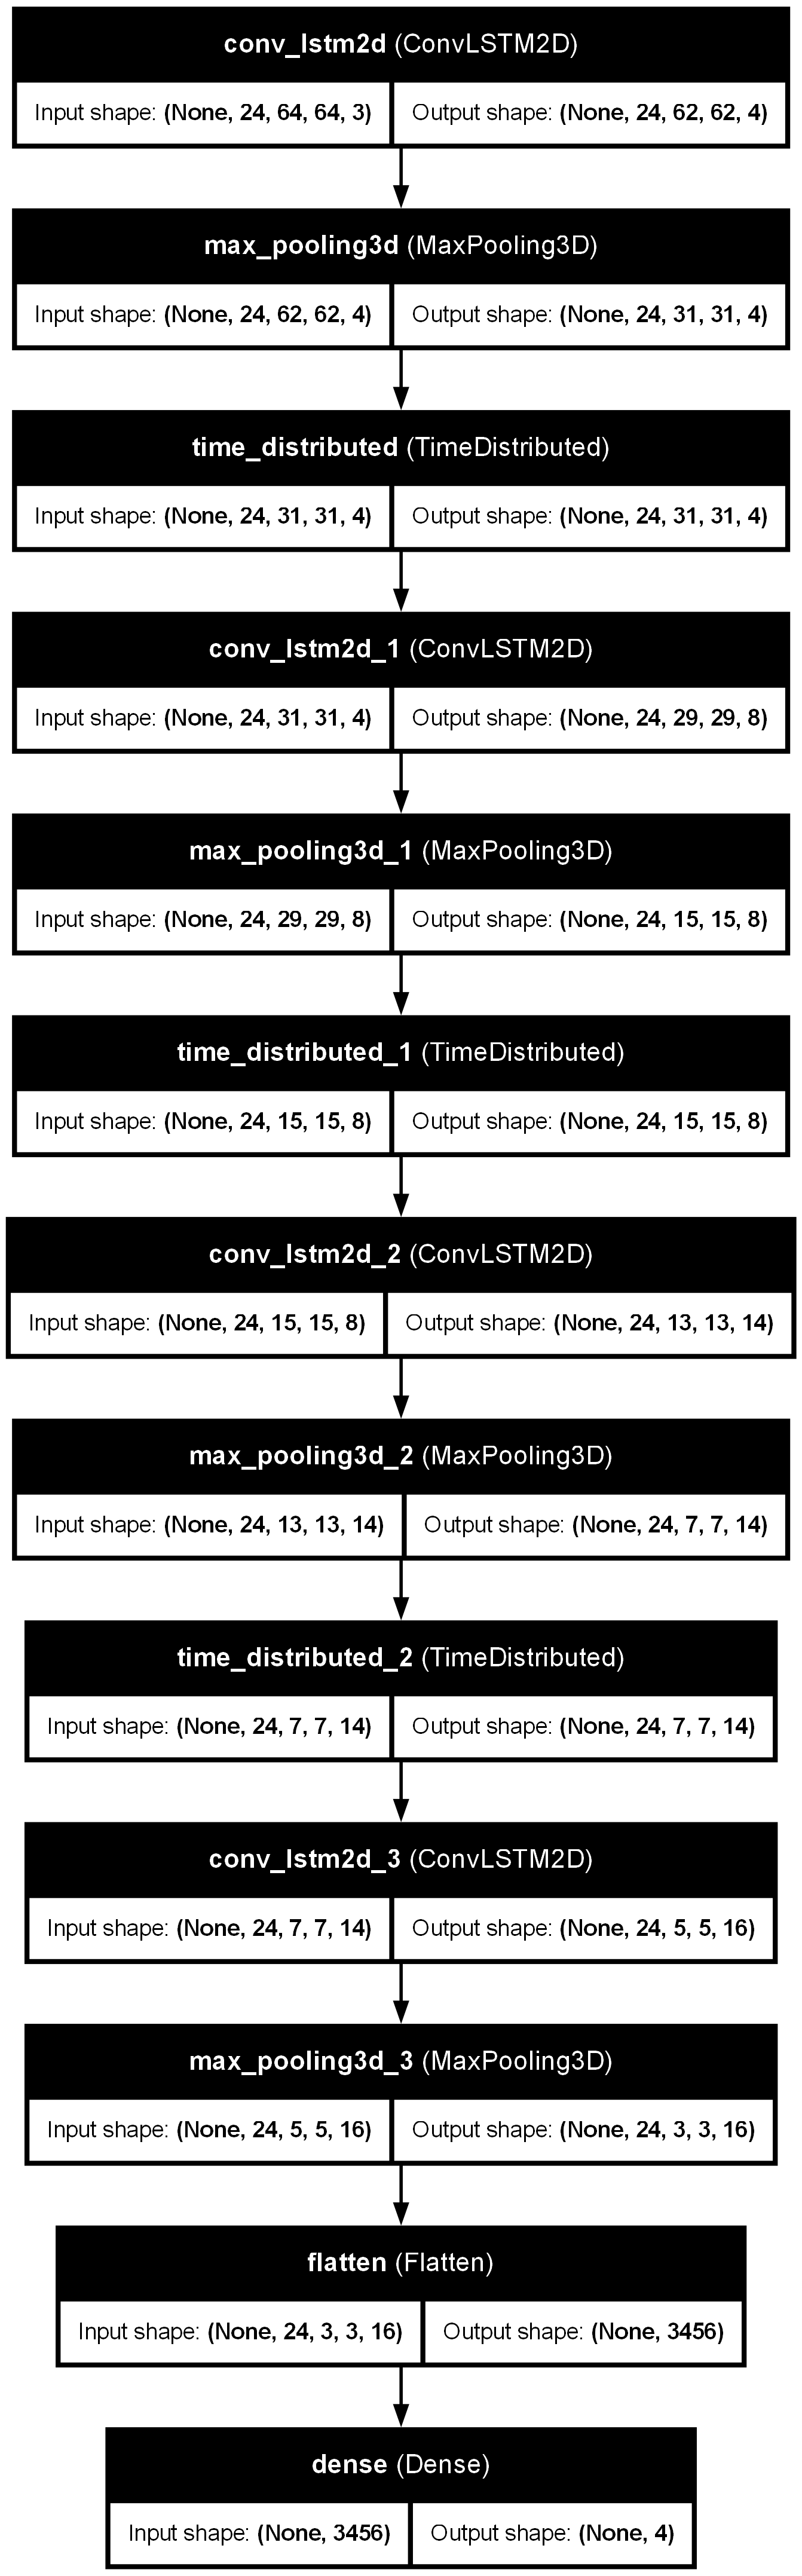

In [14]:
plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

**Compiling and Training the Model**

In [15]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

convlstm_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

convlstm_model_training_history = convlstm_model.fit(x=features_train, y=labels_train, epochs=50, batch_size=4, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 30s 229ms/step - accuracy: 0.2520 - loss: 1.4001 - val_accuracy: 0.3553 - val_loss: 1.3584
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 258ms/step - accuracy: 0.2611 - loss: 1.3747 - val_accuracy: 0.4211 - val_loss: 1.3554
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - accuracy: 0.3787 - loss: 1.2886 - val_accuracy: 0.3947 - val_loss: 1.4998
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 245ms/step - accuracy: 0.4320 - loss: 1.2392 - val_accuracy: 0.3947 - val_loss: 1.3784
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 260ms/step - accuracy: 0.4801 - loss: 1.1282 - val_accuracy: 0.3816 - val_loss: 1.3691
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 239ms/step - accuracy: 0.5387 - loss: 1.0714 - val_accuracy: 0.4211 - val_loss: 1.2631
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 19s 247ms/step - accuracy: 0.5811 - loss: 0.9869 - val_accuracy: 0.4605 - val_loss: 1.2054
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 18s 242ms/step - accuracy: 0.6286 - loss: 0.8817 - val_accu

**Evaluating the Model on Test Data**

In [16]:
model_evaluation_history = convlstm_model.evaluate(features_test, labels_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 272ms/step - accuracy: 0.6228 - loss: 0.8479


**Saving the Trained Model**

In [17]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

convlstm_model.save(model_file_name)

**Visualizing Training Performance**

In [18]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label=metric_name_2)
    
    plt.title(str(plot_name))
    plt.legend()

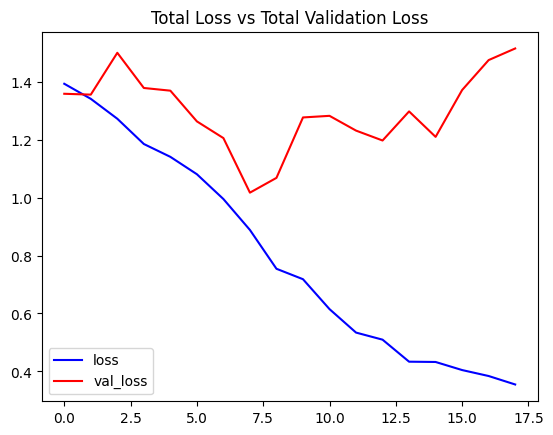

In [19]:
plot_metric(convlstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

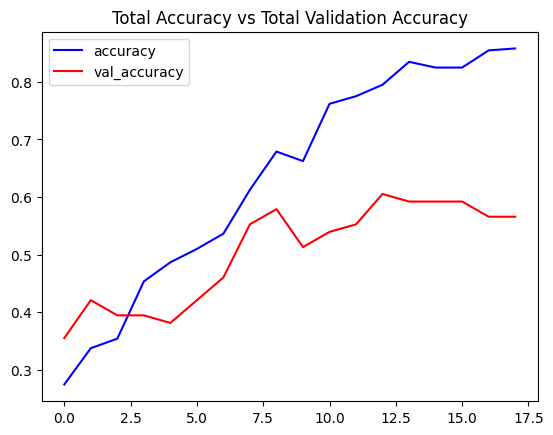

In [20]:
plot_metric(convlstm_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy') 

#### **LRCN MODEL**

<p align="center">
  <img src="images/LRCN.png" width="500">
</p>

The Long-term Recurrent Convolutional Network (LRCN) integrates CNNs for spatial feature extraction with LSTMs for temporal modeling, making it highly effective for video classification and action recognition. By processing frames sequentially, LRCN captures spatiotemporal dependencies, enabling accurate predictions in dynamic scenes. Despite high computational costs, it remains a foundational model for gesture recognition, surveillance, and autonomous systems.

**Defining the LRCN Model**

In [21]:
def create_LRCN_model():
    model = Sequential()
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
                              input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Flatten()))
    
    model.add(LSTM(32))
    
    model.add(Dense(len(CLASSES_LIST), activation='softmax'))
    
    model.summary()
    
    return model

**Initializing and Visualizing the Model**

In [22]:
LRCN_model = create_LRCN_model()
print("Model Created Successfully!")

c:\Users\rajin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_3              │ (None, 24, 64, 64, 16) │           448 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 24, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 24, 16, 16, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 24, 16, 16, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 24, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_8              │ (None, 24, 4, 4, 32)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_9              │ (None, 24, 4, 4, 64)   │        18,496 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_10             │ (None, 24, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 24, 2, 2, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 24, 2, 2, 64)   │        36,928 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 24, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 24, 64)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,060 (285.39 KB)

 Trainable params: 73,060 (285.39 KB)

 Non-trainable params: 0 (0.00 B)

Model Created Successfully!


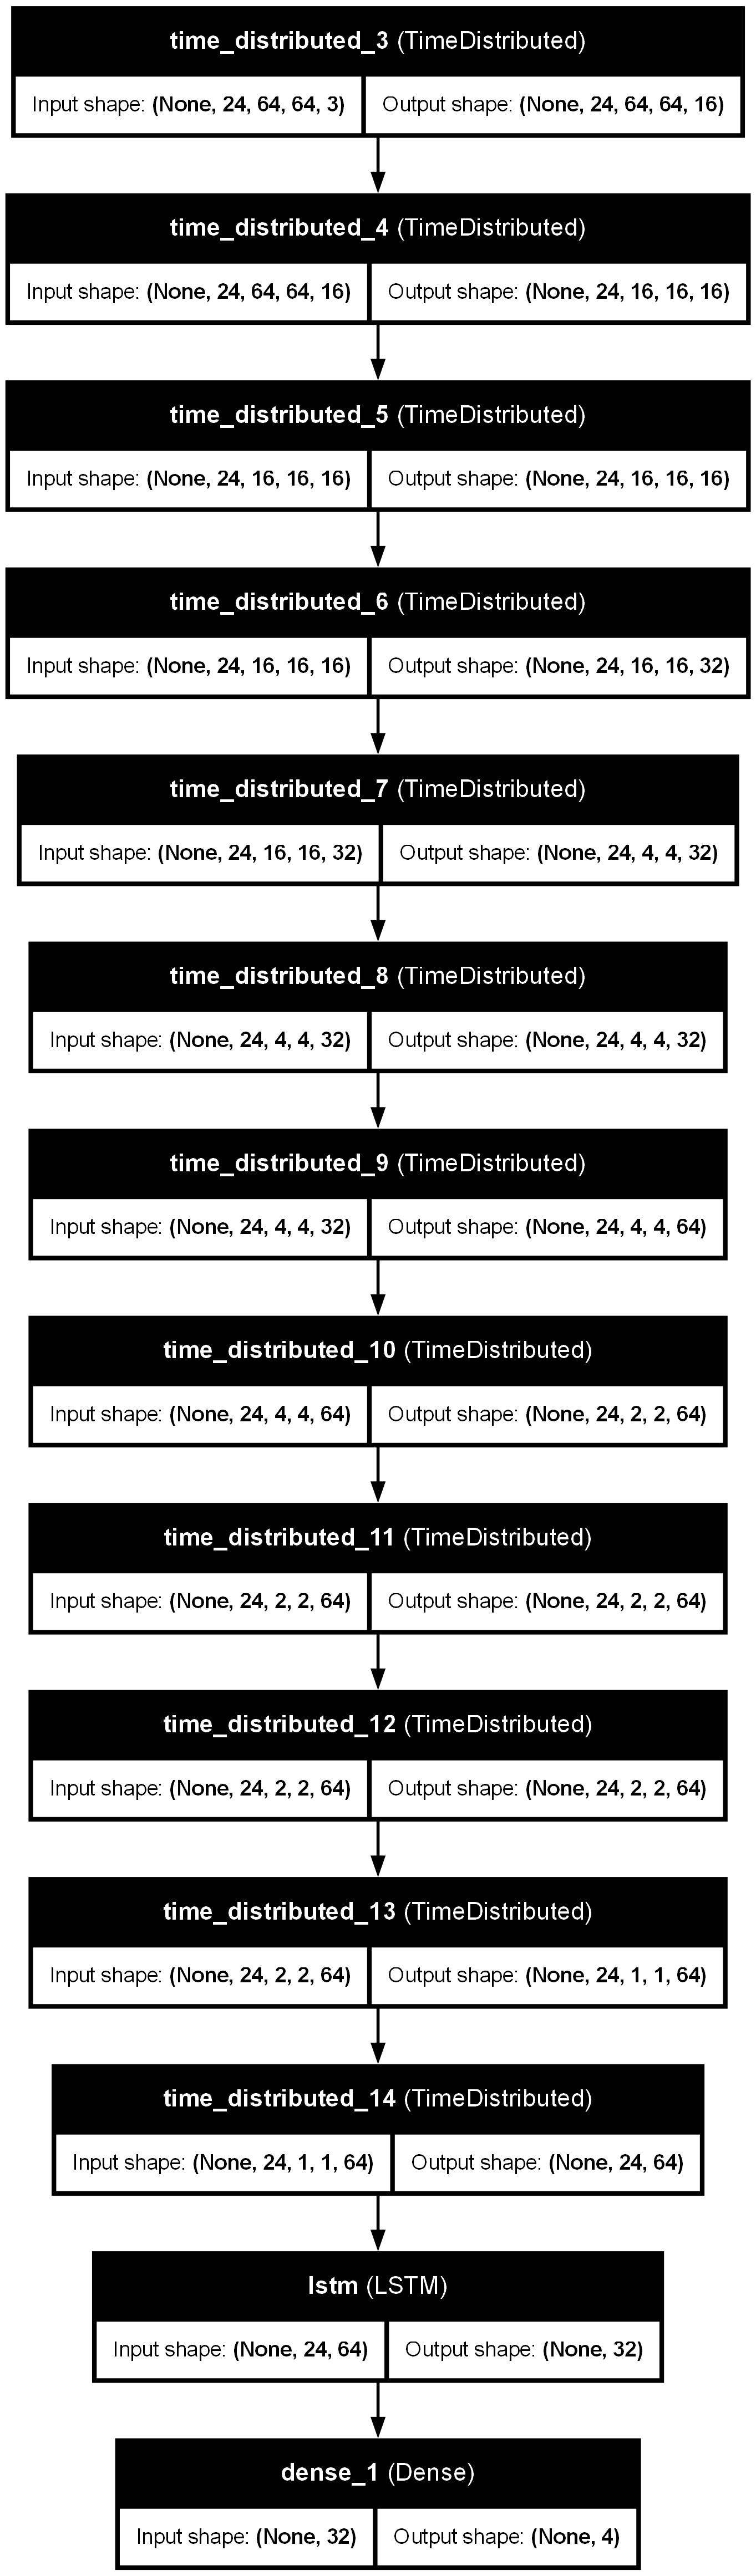

In [23]:
plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

**Compiling and Training the Model**

In [24]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)

LRCN_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

LRCN_model_training_history = LRCN_model.fit(x=features_train, y=labels_train, epochs=70, batch_size=4, shuffle=True, validation_split=0.2, callbacks=[early_stopping_callback])

Epoch 1/70
76/76 ━━━━━━━━━━━━━━━━━━━━ 26s 156ms/step - accuracy: 0.2553 - loss: 1.4152 - val_accuracy: 0.1711 - val_loss: 1.3842
Epoch 2/70
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 138ms/step - accuracy: 0.3107 - loss: 1.3647 - val_accuracy: 0.3421 - val_loss: 1.3555
Epoch 3/70
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 0.3698 - loss: 1.3038 - val_accuracy: 0.4737 - val_loss: 1.2648
Epoch 4/70
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 0.3938 - loss: 1.2566 - val_accuracy: 0.3816 - val_loss: 1.2863
Epoch 5/70
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 0.4282 - loss: 1.1678 - val_accuracy: 0.4211 - val_loss: 1.2513
Epoch 6/70
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 0.4849 - loss: 1.0749 - val_accuracy: 0.4605 - val_loss: 1.2888
Epoch 7/70
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 140ms/step - accuracy: 0.3998 - loss: 1.2974 - val_accuracy: 0.4211 - val_loss: 1.2659
Epoch 8/70
76/76 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.5996 - loss: 1.0335 - val_accu

**Evaluating the Model on Test Data**

In [25]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.7858 - loss: 0.5645


**Saving the Trained Model**

In [26]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
    
model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

LRCN_model.save(model_file_name)


**Visualizing Training Performance**

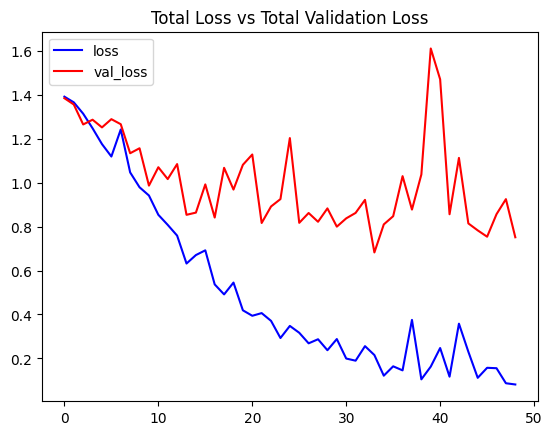

In [27]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

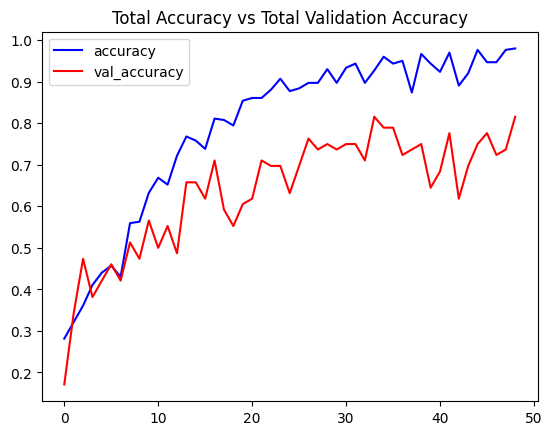

In [28]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

**YouTube Video Downloader using yt-dlp**


sample videoclip link: https://www.youtube.com/watch?v=ohNbC4gmymE

In [29]:
import yt_dlp
import os

def youtube_video_downloader(url):
    save_path = "./test_videoes"
    os.makedirs(save_path, exist_ok=True)
    
    output_file_path = os.path.join(save_path, 'videoplayback.mp4')
    
    if os.path.exists(output_file_path):
        os.remove(output_file_path)
    
    ydl_opts = {
        'format': 'best',
        'outtmpl': output_file_path,
    }
    
    with yt_dlp.YoutubeDL(ydl_opts) as ydl:
        ydl.download([url])
    
    print(f"Download complete. Video saved to {output_file_path}")

if __name__ == "__main__":
    video_url = input("Enter YouTube Video URL: ")
    youtube_video_downloader(video_url)


[youtube] Extracting URL: https://www.youtube.com/watch?v=ohNbC4gmymE
[youtube] ohNbC4gmymE: Downloading webpage
[youtube] ohNbC4gmymE: Downloading tv client config
[youtube] ohNbC4gmymE: Downloading player c8dbda2a
[youtube] ohNbC4gmymE: Downloading tv player API JSON
[youtube] ohNbC4gmymE: Downloading ios player API JSON
[youtube] ohNbC4gmymE: Downloading m3u8 information
[info] ohNbC4gmymE: Downloading 1 format(s): 18
[download] Destination: test_videoes\videoplayback.mp4
[download] 100% of  143.17KiB in 00:00:00 at 1.80MiB/s     
Download complete. Video saved to ./test_videoes\videoplayback.mp4


**Video Action Prediction using the ConvLSTM Model**

In [30]:
def predict_on_video_using_convlstm(video_file_path, output_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
    
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    predicted_class_name = ''
    
    while video_reader.isOpened():
        ok, frame = video_reader.read()
        if not ok:
            break
        
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)
        
        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]
        
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        video_writer.write(frame)
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

        
    video_reader.release()
    video_writer.release()

**Generating Action Predictions on a Video using trained ConvLSTM model**

In [31]:
output_video_file_path = f'./test_videoes/videoplayback.mp4-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

input_video_file_path = f'./test_videoes/videoplayback.mp4'

predict_on_video_using_convlstm(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━

**Predicting a Single Action from a Video using the trained ConvLSTM model**

In [32]:
def predict_single_action_using_convlstm(video_file_path, SEQUENCE_LENGTH):
   
    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames_list = []
    predicted_class_name = ''
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read() 
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    predicted_labels_probabilities = convlstm_model.predict(np.expand_dims(frames_list, axis = 0))[0]
    predicted_label = np.argmax(predicted_labels_probabilities)
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
    
    video_reader.release()

**Executing Single Action Prediction on a Video using the trained ConvLSTM model**

In [33]:
input_video_file_path = f'./test_videoes/videoplayback.mp4'

predict_single_action_using_convlstm(input_video_file_path, SEQUENCE_LENGTH)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Action Predicted: Swing
Confidence: 0.48037004470825195


**Video Action Prediction using the LRCN Model**

In [34]:
def predict_on_video_using_lrcn(video_file_path, output_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'),
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))
    
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    predicted_class_name = ''
    
    while video_reader.isOpened():
        ok, frame = video_reader.read()
        if not ok:
            break
        
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_queue.append(normalized_frame)
        
        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]
        
        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        video_writer.write(frame)
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')

        
    video_reader.release()
    video_writer.release()

**Generating Action Predictions on a Video using trained LRCN model**

In [35]:
output_video_file_path = f'./test_videoes/videoplayback.mp4-Output-SeqLen{SEQUENCE_LENGTH}.mp4'

input_video_file_path = f'./test_videoes/videoplayback.mp4'

predict_on_video_using_lrcn(input_video_file_path, output_video_file_path, SEQUENCE_LENGTH)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━

**Predicting a Single Action from a Video using the trained LRCN model**

In [36]:
def predict_single_action_using_lrcn(video_file_path, SEQUENCE_LENGTH):
   
    video_reader = cv2.VideoCapture(video_file_path)
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames_list = []
    predicted_class_name = ''
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH),1)

    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read() 
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)

    predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_list, axis = 0))[0]
    predicted_label = np.argmax(predicted_labels_probabilities)
    predicted_class_name = CLASSES_LIST[predicted_label]
    
    print(f'Action Predicted: {predicted_class_name}\nConfidence: {predicted_labels_probabilities[predicted_label]}')
        
    video_reader.release()

**Executing Single Action Prediction on a Video using the trained LRCN model**

In [37]:
input_video_file_path = f'./test_videoes/videoplayback.mp4'

predict_single_action_using_lrcn(input_video_file_path, SEQUENCE_LENGTH)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Action Predicted: Biking
Confidence: 0.9401558041572571


In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Generate predictions for the test set
y_pred_convlstm = convlstm_model.predict(features_test)
y_pred_lrcn = LRCN_model.predict(features_test)

# Convert predicted probabilities to class labels
y_pred_convlstm_labels = np.argmax(y_pred_convlstm, axis=1)
y_pred_lrcn_labels = np.argmax(y_pred_lrcn, axis=1)
y_true_labels = np.argmax(labels_test, axis=1)  # Convert one-hot encoded labels to class labels

# Calculate Precision, Recall, and F1-score for ConvLSTM model
precision_convlstm = precision_score(y_true_labels, y_pred_convlstm_labels, average='weighted')
recall_convlstm = recall_score(y_true_labels, y_pred_convlstm_labels, average='weighted')
f1_convlstm = f1_score(y_true_labels, y_pred_convlstm_labels, average='weighted')

# Calculate Precision, Recall, and F1-score for LRCN model
precision_lrcn = precision_score(y_true_labels, y_pred_lrcn_labels, average='weighted')
recall_lrcn = recall_score(y_true_labels, y_pred_lrcn_labels, average='weighted')
f1_lrcn = f1_score(y_true_labels, y_pred_lrcn_labels, average='weighted')

# Print the results
print("ConvLSTM Model Metrics:")
print(f"Precision: {precision_convlstm:.4f}")
print(f"Recall: {recall_convlstm:.4f}")
print(f"F1 Score: {f1_convlstm:.4f}\n")

print("LRCN Model Metrics:")
print(f"Precision: {precision_lrcn:.4f}")
print(f"Recall: {recall_lrcn:.4f}")
print(f"F1 Score: {f1_lrcn:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
ConvLSTM Model Metrics:
Precision: 0.6407
Recall: 0.6142
F1 Score: 0.6136

LRCN Model Metrics:
Precision: 0.7692
Recall: 0.7795
F1 Score: 0.7717
